# TRAVEL INSURANCE CLAIM BY MUHAMMAD FARIS AULIA GANIS

## BUSINESS PROBLEM

**Context**

Travel insurance is a type of insurance that provides protection as long as we travel both domestically and abroad. Several countries have even required travelers to have travel insurance, for example, countries in Europe and America. The amount of premium depends on the coverage desired, the length of the trip, and the purpose of the trip. A company engaged in travel insurance wants to know the policyholder who will submit an insurance claim for coverage. Policyholder data at insurance companies is historical data consisting of destinations, insurance products, and so on.

Insurance companies base their business around assuming and diversifying risk. They generate revenue by charging premiums then investing those premiums in other interest generating assets. 

To make profit insurance companies ensure that the premiums that they charge are greater than any future claims.

Target :</br>
0 : Did not claimed</br>
1 : Claimed

Source: <br>
https://www.fe.training/free-resources/fig/how-do-insurance-companies-make-money/ <br>
https://www.investopedia.com/ask/answers/052015/what-main-business-model-insurance-companies.asp

**Problem Statement**

A travel insurance company wants to predict which policyholders are likely to submit an insurance claim for coverage, in order to proactively identify and mitigate potential losses.

**Goals**

Using a classification machine learning model, the company can analyze historical policyholder data such as destinations, insurance products, and trip details **to accurately predict which policyholders are at a higher risk of submitting a claim**. This will allow the company to **take preventative measures** to compensate costs of claims and improve overall financial performance.

**Analytic Approach**

Next is to  analyze the data to find patterns from the existing features to differentiate policyholders who made a claim and who did not.

Then build a classification model that will help the company to predict if a policyholder will likely submit a claim or not.

**Metric Evaluation**

Based on our goals, the model must be good at predicting policyholders who would make a claim in the future. So in this case we would need to reduce the number of false positive rate, meaning we would be losing more money if the model predicted a policy holder who did not claim but in actuallity they claimed hence precision score will be our evaluation metric.

Type 1 error : False Positive  
Consequence: The company cannot charge more / extra premiums to a policyholder who in reality made a claim in the future but it predicted "not going to claim" by the model. Which means the company loses money.

Type 2 error : False Negative  
Consequence: Overcharging policyholders who is likely not going to claim in the future. 

## DATA UNDERSTANDING

In [280]:
# Library

## Basic Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Pre Modelling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline

## Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

Note : 
- Dataset is imbalanced (by looking at the target column value counts below)
- Every row of data represent policyholder historical data whether they have claimed the travel insurance or not

**Attribute Information**

| Attribute | Data Type| Description |
| --- | --- | --- |
| Agency | object | Name of agency |
| Agency Type | object | Type of travel insurance agencies |
| Distribution Channel | object | Channel of travel insurance agencies |
| Product Name | object | Name of the travel insurance products |
| Gender | object | Gender of insured |
| Duration | integer | Duration of travel |
| Destination | object | Destination of travel |
| Net Sales | float | Amount of sales of travel insurance policies |
| Commision (in value) | float | Commission received for travel insurance agency |
| Age | integer | Age of insured |
| Claim | object | Claim status |

In [281]:
# Load dataset
df = pd.read_csv(r'data_travel_insurance.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


### Exploratory Data Analysis

From the data description below we can see that:

1. There are 44328 number of columns
2. Gender seems to have a lot of missing value (will explore further below in data cleaning)
3. Most used *Agency* and *Agency Type* is `EPX` and `Travel Agency` respectively
4. Most used *Distribution Channel* is through `online`
5. Most product used is `Cancellation Plan`
6. Most visited country is `Singapore`
7. Lowest travel duration is `-1`, could be an anomaly (will explore further below in data cleaning)
8. Oldest person with travel insurance is `118 years old`
9. Lowest *Net Sales* and *Commision* is `-357.50` and `0` respectively (we will assume these values in dollars, $)
10. Highest *Net Sales* and *Commision* is `810` and `283.50` respectively

In [282]:
df.describe(include= 'all')

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
count,44328,44328,44328,44328,12681,44328.000000,44328,44328.000000,44328.000000,44328.000000,44328
unique,16,2,2,26,2,NaN,138,NaN,NaN,NaN,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,NaN,SINGAPORE,NaN,NaN,NaN,No
freq,24656,32113,43572,12979,6504,NaN,9267,NaN,NaN,NaN,43651
mean,NaN,NaN,NaN,NaN,NaN,49.424292,NaN,40.550948,9.707692,39.925600,NaN
std,NaN,NaN,NaN,NaN,NaN,109.153961,NaN,48.661970,19.625637,13.954926,NaN
min,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,-357.500000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,18.000000,0.000000,35.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,26.500000,0.000000,36.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,48.000000,11.550000,43.000000,NaN


The target data is imbalanced clearly by looking at value counts from column 'Claim'

In [283]:
df['Claim'].value_counts(normalize= True)

No     0.984727
Yes    0.015273
Name: Claim, dtype: float64

In [284]:
df['Claim'].value_counts()

No     43651
Yes    677  
Name: Claim, dtype: int64

From Fig 1.0 below it can be seen that there are more Policyholders who get travel insurances from `Travel Agency` rather than from `Airlines`. <br>
However there are more policyholders who *claimed* their insurance when getting it from Airlines rather than from Travel Agencies.

In [285]:
df.groupby('Agency Type')['Claim'].value_counts()

Agency Type    Claim
Airlines       No       11776
               Yes      439  
Travel Agency  No       31875
               Yes      238  
Name: Claim, dtype: int64

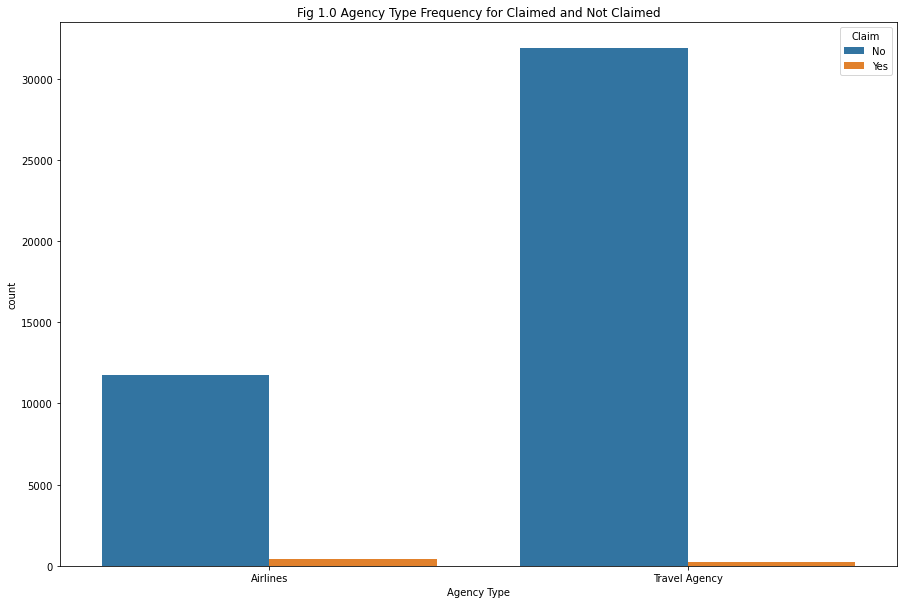

In [286]:
plt.figure(figsize= (15, 10))
sns.countplot(df['Agency Type'], hue= df['Claim'])
plt.title("Fig 1.0 Agency Type Frequency for Claimed and Not Claimed")
plt.show()


From Fig 2.0 below it can be seen that the dataset contain more males than females who uses travel insurance but only by a small margin. 

In [287]:
df.groupby(['Gender'])['Claim'].value_counts()

Gender  Claim
F       No       5923
        Yes      254 
M       No       6283
        Yes      221 
Name: Claim, dtype: int64

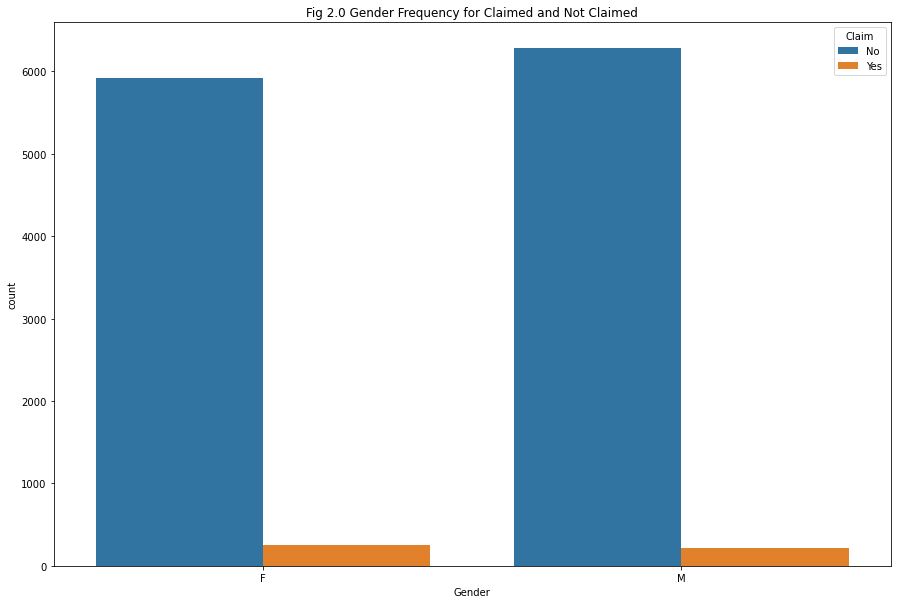

In [288]:
plt.figure(figsize= (15, 10))
sns.countplot(df['Gender'], hue= df['Claim'])
plt.title("Fig 2.0 Gender Frequency for Claimed and Not Claimed")
plt.show()

From Fig 3.0 below it can be seen that most policyholders get their travel insurance through online channel. <br>
Additionally both online and offline channels have a low number of policyholders who claimed their insurance. 

In [289]:
df.groupby('Distribution Channel')['Claim'].value_counts()

Distribution Channel  Claim
Offline               No       745  
                      Yes      11   
Online                No       42906
                      Yes      666  
Name: Claim, dtype: int64

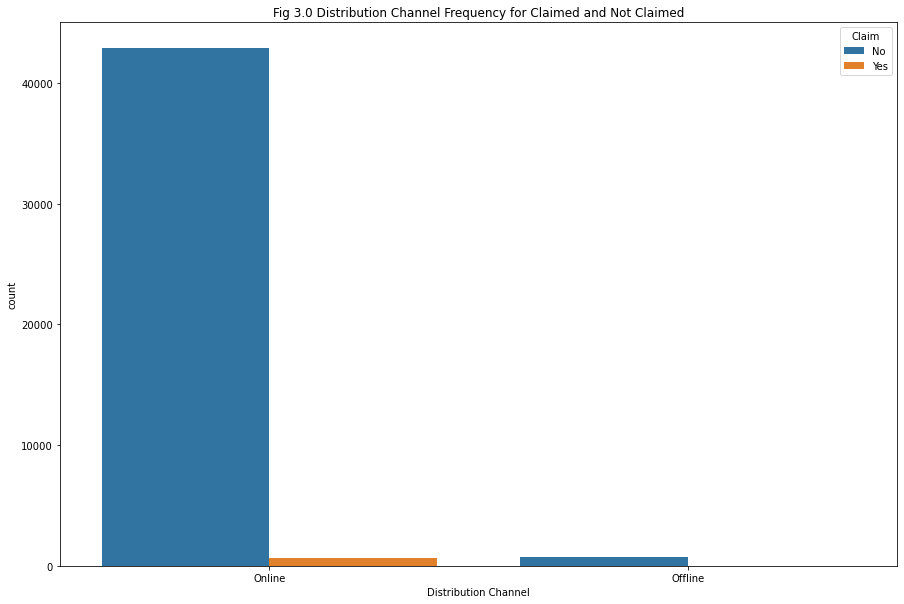

In [290]:
plt.figure(figsize= (15, 10))
sns.countplot(df['Distribution Channel'], hue= df['Claim'])
plt.title("Fig 3.0 Distribution Channel Frequency for Claimed and Not Claimed")
plt.show()

## Data Preprocessing

In this section we would be doing data wrangling and cleaning, feature selection and feature engineering before we move on to building and benchmarking models.

### Data Cleaning

In data cleaning section we would be dealing with treating missing values by either dropping the feature if it is not necessary or by imputing them with values that are relevant and reasonable.
Next we would be checking anomalies inside the data and treat them appropriately. For example checking the 'age' column if there are any age that are out of the ordinary and how we would deal with them will be explored below.

Before moving further let's check on duplicated data. by using `.duplicated().sum()` it can be seen below that there are 4667 duplicates. However after viewing all the 'duplicated' rows, no two rows are an exact/mirror of each other. So we would treat this dataset as having no duplicates.

In [291]:
# Make a copy of dataset
df_clean = df.copy()

In [292]:
# Check duplicates
df_clean.duplicated().sum()

4667

In [293]:
# Duplicate percentage 
4667 / len(df_clean) *100

10.528334235697526

In [294]:
# View all duplicates
duplicates = df_clean[df_clean.duplicated(keep= False)]
duplicates

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
5,EPX,Travel Agency,Online,Cancellation Plan,NaN,2,SINGAPORE,10.0,0.00,36,No
31,EPX,Travel Agency,Online,Cancellation Plan,NaN,19,UNITED KINGDOM,10.0,0.00,36,No
...,...,...,...,...,...,...,...,...,...,...,...
44309,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,49,VIET NAM,20.0,0.00,36,No
44311,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,5,THAILAND,29.7,17.82,38,No
44313,EPX,Travel Agency,Online,Cancellation Plan,NaN,5,CHINA,14.0,0.00,36,No
44315,EPX,Travel Agency,Online,1 way Comprehensive Plan,NaN,5,THAILAND,20.0,0.00,36,No


After checking the total missing values, only the column *Gender* contain missing values. However we must double check all other columns further to make sure that there are no values such as *?* or *-* which the code detect as not a missing value.

In [295]:
# Check the number of missing values for every columns
df_clean.isnull().sum()

Agency                  0    
Agency Type             0    
Distribution Channel    0    
Product Name            0    
Gender                  31647
Duration                0    
Destination             0    
Net Sales               0    
Commision (in value)    0    
Age                     0    
Claim                   0    
dtype: int64

From the table below we can conclude that all the missing values are only in the column *Gender* as *nan*. There are no missing values anomalies such as ? and - in other columns. The missing values from the Gender column could be that policyholders did not input or specify their genders.

In [296]:
pd.set_option('display.max_colwidth', -1)

list_item = []
for col in df_clean.columns:
    list_item.append([col, df_clean[col].dtype, df_clean[col].isna().sum(), round((df_clean[col].isna().sum()/len(df_clean[col])) * 100,2), df_clean[col].nunique(), df_clean[col].unique()]);

description = pd.DataFrame(
    columns=['features', 'data_type', 'null', 'null_percentage', 'n_unique', 'unique'],
    data=list_item
)
description

,features,data_type,null,null_percentage,n_unique,unique
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, KML, TST, TTW, JWT, ADM, CCR, CBH]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, Value Plan, 24 Protect, Annual Travel Protect Gold, Comprehensive Plan, Ticket Protector, Travel Cruise Protect, Single Trip Travel Protect Silver, Individual Comprehensive Plan, Gold Plan, Annual Gold Plan, Child Comprehensive Plan, Premier Plan, Annual Travel Protect Silver, Single Trip Travel Protect Platinum, Annual Travel Protect Platinum, Spouse or Parents Comprehensive Plan, Travel Cruise Protect Family]"
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 10, 4736, 15, 17, 99, 173, 74, 82, 66, 156, 39, 95, 98, 111, 430, 53, 77, 87, 70, 151, 45, 54, 114, 118, 62, 28, 112, 326, 22, 59, 44, 21, 97, 63, 60, 51, 180, 160, 368, 65, 93, 71, 57, 0, 76, 69, 110, 146, 116, 129, 84, ...]"
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED ARAB EMIRATES, IRAN, ISLAMIC REPUBLIC OF, TAIWAN, PROVINCE OF CHINA, POLAND, CANADA, OMAN, PHILIPPINES, GREECE, BELGIUM, TURKEY, BRUNEI DARUSSALAM, DENMARK, SWITZERLAND, NETHERLANDS, SWEDEN, MYANMAR, KENYA, CZECH REPUBLIC, FRANCE, RUSSIAN FEDERATION, PAKISTAN, ARGENTINA, TANZANIA, UNITED REPUBLIC OF, SERBIA, ITALY, CROATIA, NEW ZEALAND, PERU, MONGOLIA, CAMBODIA, QATAR, NORWAY, LUXEMBOURG, MALTA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, ISRAEL, SAUDI ARABIA, AUSTRIA, PORTUGAL, NEPAL, UKRAINE, ESTONIA, ICELAND, BRAZIL, MEXICO, CAYMAN ISLANDS, PANAMA, BANGLADESH, TURKMENISTAN, BAHRAIN, KAZAKHSTAN, TUNISIA, IRELAND, ETHIOPIA, NORTHERN MARIANA ISLANDS, MALDIVES, SOUTH AFRICA, VENEZUELA, COSTA RICA, JORDAN, MALI, CYPRUS, MAURITIUS, LEBANON, KUWAIT, AZERBAIJAN, HUNGARY, BHUTAN, BELARUS, MOROCCO, ECUADOR, UZBEKISTAN, CHILE, FIJI, PAPUA NEW GUINEA, ANGOLA, FRENCH POLYNESIA, NIGERIA, MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF, NAMIBIA, GEORGIA, COLOMBIA, ...]"
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, 21.04, 33.0, 204.6, 34.0, 30.55, 35.0, 49.5, 18.0, 98.0, 77.0, 69.3, 64.0, 0.32, 227.7, 48.5, -216.75, 24.0, 161.0, 99.0, 59.4, 45.0, 37.0, 44.0, 19.0, 75.0, 39.0, 17.55, -59.4, 51.0, -29.7, 80.25, 63.0, 12.0, 72.0, 53.0, 38.0, 17.0, 54.0, 69.0, 115.0, 76.3, 19.5, 29.5, 62.0, 11.0, 3.73, 79.0, 138.6, 22.5, 59.0, 5.59, 33.5, 53.25, 62.25, 93.0, -12.0, 1.03, 27.0, 56.5, 39.6, 28.0, 41.0, 97.0, 128.0, 43.0, 66.0, 26.5, 0.19, ...]"
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 0.09, 6.0, 136.62, 31.53, 54.19, 11.55, 10.15, 40.25, 59.4, 35.64, 15.75, 12.95, 28.5, 9.75, 4.39, 20.06, 18.0, 4.25, 19.07, 4.88, 7.38, 15.5, 1.05, 83.16, 14.7, 15.4, 1.57, 8.38, 13.31, 15.56, 0.29, 8.0, 36.73, 13.65, 20.3, 5.0, 10.0, 6.63, 0.05, 24.15, 29.05, 8.88, 14.0, 3.38, 15.88, 0.45, 10.89, 47.52, 0.37, 27.25, 18.13, 15.6, 70.2, 12.4, 72.94, 8.63, 4.63, 6.75, 11.25, 0.96, 53.46, 77.22, 1.13, 4.94, 1.73, 10.38, 58.45, 23.5, 6.94, 6.13, 41.42, 17.5, 13.16, 0.14, 3.23, 15.93, ...]"
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 3

Since the missing values from the column *Gender* take up a huge protion of our data, we would not be dropping the *nan* values, rather we would replace them with a string 'unspecified'.

In [297]:
# Replacing nan values witj 'unspecified'
df_clean['Gender'].fillna('unspecified', inplace=True)

In [298]:
# Check if the missing values are properly filled / replaced
df_clean.isnull().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Gender                  0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64

Can be seen that all 31647 *nan* values have been converted into 'unspecified'.

In [299]:
# Check if the missing values are properly filled / replaced
df_clean['Gender'].value_counts()

unspecified    31647
M              6504 
F              6177 
Name: Gender, dtype: int64

We would now be checking for any data anomalies for columns that would be relevant later on for feature selection and modeling.

Let's check on the column *duration* first. It can be seen that there is a -1 long travel. As the data is in *days* it is not realistic for a travel insurance to have a duration of -1.

In [300]:
df_clean['Duration'].unique()

array([ 365,    4,   19,   20,    8,    2,   25,   90,   24,   43,  103,
        376,    6,   16,   27,   34,    3,   14,   12,   31,    5,    7,
         56,   29,   30,   58,    9,   38,   42,   11,   13,   40,   79,
        370,  366,   26,   83,   55,   18,  100,    1,   35,   36,   75,
         23,   73,   32,  232,   37,   10, 4736,   15,   17,   99,  173,
         74,   82,   66,  156,   39,   95,   98,  111,  430,   53,   77,
         87,   70,  151,   45,   54,  114,  118,   62,   28,  112,  326,
         22,   59,   44,   21,   97,   63,   60,   51,  180,  160,  368,
         65,   93,   71,   57,    0,   76,   69,  110,  146,  116,  129,
         84,   33,  149,   68,   64,  101,  145,   88,  222,  176,  165,
        169,  387,   49,  109,   41,  381,   50,  161,  154,  330,   46,
         78,   47,  121,  106,  140,   91,  104,  134,  393,  282,  123,
        172,   86,  102,  314,  386,  383,   81,  283,  115,  144,   61,
        206,  213,  271,  174,  152,  122,   94,  2

Now we check how many columns there are containing Duration of -1. Can also be be seen that the Age is 118, we can assume that these are misinput from policiy holders or travel agency. <br>
As there are only two columns, we would be dropping these.

In [301]:
df_clean[df_clean['Duration'] == -1]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
26228,JZI,Airlines,Online,Basic Plan,unspecified,-1,MALAYSIA,18.0,6.3,118,No
26494,JZI,Airlines,Online,Basic Plan,unspecified,-1,BRUNEI DARUSSALAM,18.0,6.3,118,No


In [302]:
# Drop the two columns above based on their index number
df_clean = df_clean.drop([26228, 26494])

There are no anomalies data from the rest of the columns as seen below.

In [303]:
df_clean['Net Sales'].unique()

array([216.  ,  10.  ,  22.  , ...,   4.38,  16.54,  49.39])

In [304]:
df_clean['Commision (in value)'].unique()

array([5.4000e+01, 0.0000e+00, 7.7000e+00, 4.0000e+00, 9.1000e+00,
       6.3210e+01, 1.0500e+01, 1.1880e+01, 1.7820e+01, 2.3400e+01,
       7.5000e+00, 5.9400e+00, 4.3750e+01, 2.3760e+01, 7.3600e+00,
       1.3299e+02, 9.5700e+00, 7.6400e+00, 1.2250e+01, 2.9700e+01,
       6.3000e+00, 5.6300e+00, 4.1580e+01, 5.2500e+00, 9.0000e-02,
       6.0000e+00, 1.3662e+02, 3.1530e+01, 5.4190e+01, 1.1550e+01,
       1.0150e+01, 4.0250e+01, 5.9400e+01, 3.5640e+01, 1.5750e+01,
       1.2950e+01, 2.8500e+01, 9.7500e+00, 4.3900e+00, 2.0060e+01,
       1.8000e+01, 4.2500e+00, 1.9070e+01, 4.8800e+00, 7.3800e+00,
       1.5500e+01, 1.0500e+00, 8.3160e+01, 1.4700e+01, 1.5400e+01,
       1.5700e+00, 8.3800e+00, 1.3310e+01, 1.5560e+01, 2.9000e-01,
       8.0000e+00, 3.6730e+01, 1.3650e+01, 2.0300e+01, 5.0000e+00,
       1.0000e+01, 6.6300e+00, 5.0000e-02, 2.4150e+01, 2.9050e+01,
       8.8800e+00, 1.4000e+01, 3.3800e+00, 1.5880e+01, 4.5000e-01,
       1.0890e+01, 4.7520e+01, 3.7000e-01, 2.7250e+01, 1.8130e

In [305]:
df_clean['Age'].unique()

array([ 57,  33,  26,  59,  28,  36,  22,  39,  27,  48,  43,  51,  65,
        47,  35,  54,  23,  46,  58,  42,  31,  29,  37,  68,   8,  32,
        61,  49,  56,  25,  50,  34,  38,  44, 118,  45,  53,  20,  30,
        41,  69,  52,  40,  70,  76,  74,  66,  63,  55,  21,  60,  75,
        24,  62,  73,  64,  71,   5,  14,  72,  84,  81,  16,  19,  67,
        83,  13,  79,  18,   9,  80,  17,  82,  78,  15,  77,  87,  88,
        11,  12,  86,   7,  10,   2,   3,   1,   4,  85,   0], dtype=int64)

### Feature Selection & Feature Engineering

We would be using all the features for our model. <br> But beforehand, we will convert all the categorical columns into numerical.

First we convert our target column *Claim* from yes or no into 1 and 0 based on their respective class stated earlier; yes into 1 and no into 0.

In [306]:
# Convert 'Claim' column into 1s and 0s.
df_clean['Claim'] = df_clean['Claim'].apply(lambda x: 0 if x == 'No' else 1)

In [307]:
df_clean['Claim'].value_counts()

0    43649
1    677  
Name: Claim, dtype: int64

We would be dropping the column `Distribution Channel` as most policy holders get their insurance via online channel.

Next we will encode the categorical features:

1. Encode columns `Agency`, `Product Name` and `Destination` with *Binary Encoding* because the categories in these columns do not have order and the number of unique values are a lot.
2. Encode columns `Agency Type`, and `Gender` with *One Hot Encoding* because the categories in these columns do not have order and the number of unique values are few.

In [308]:
df_clean.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,unspecified,4,MALAYSIA,10.0,0.0,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,unspecified,20,UNITED STATES,112.0,0.0,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,0


In [309]:
# Categorical features into numerical
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop= 'first'), ['Agency Type', 'Gender']),
    ('binary', ce.BinaryEncoder(), ['Agency', 'Product Name', 'Destination'])
], remainder= 'passthrough')

In [310]:
# Define X and y
X = df_clean.drop(columns= ['Claim', 'Distribution Channel'], axis= 1)
y = df_clean['Claim']

In [311]:
# Splitting testing and training data with 20:80 proportion
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,
    stratify= y,  
    test_size= 0.2,
    random_state= 2023)

## Modeling

In [312]:
# Algorithm to be used
logreg = LogisticRegression()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()

### Model Benchmarking : K-Fold

In [313]:
# Cross validation

# Models
models = [logreg, knn, tree, rf]

score_precision = []
mean_precision = []
std_precision = []

# Loop every models for each metrics
for i in models:

    crossval = StratifiedKFold(n_splits= 5)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    # precision
    model_cv_precision = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv= crossval,
        scoring= 'precision')

    # print(model_cv_precision, i)

    score_precision.append(model_cv_precision)
    mean_precision.append(model_cv_precision.mean())
    std_precision.append(model_cv_precision.std())

precision_before_tuning = pd.DataFrame({'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],'mean precision': mean_precision, 'std': std_precision}).set_index('model').sort_values(by= 'mean precision', ascending= False)
precision_before_tuning


,mean precision,std
model,,
Random Forest,0.105035,0.060753
Decision Tree,0.049652,0.010320
KNN,0.028571,0.057143
Logistic Regression,0.000000,0.000000


The best algorithm based on the mean precision score using default parameters is `Random Forest`. However all of the scores are very low (<10%)

### Model Benchmarking : Test Data

In [314]:
models = [logreg, knn, tree, rf]
score_precision = []

def y_pred_function(i):
    estimator= Pipeline([
        ('preprocess', transformer),
        ('model', i)])
    X_train, X_test
    
    estimator.fit(X_train, y_train)
    return(estimator, estimator.predict(X_test), X_test)

for i, j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']):
    estimator, y_pred, X_test = y_pred_function(i)
    print(j,'\n', classification_report(y_test, y_pred))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8731
           1       0.00      0.00      0.00       135

    accuracy                           0.98      8866
   macro avg       0.49      0.50      0.50      8866
weighted avg       0.97      0.98      0.98      8866

KNN 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8731
           1       0.00      0.00      0.00       135

    accuracy                           0.98      8866
   macro avg       0.49      0.50      0.50      8866
weighted avg       0.97      0.98      0.98      8866

Decision Tree 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8731
           1       0.06      0.08      0.07       135

    accuracy                           0.97      8866
   macro avg       0.52      0.53      0.53      8866
weighted avg       0.97      0

With the test data `Random Forest` has the best performance but only with a precision score of 0.11 in guessing the positive class.

Since the dataset is highly imbalanced with a 98% to 2% ratio, let's try to compare undersampling and oversampling method on the dataset.

### Random Under Sampling

In [315]:
from imblearn.under_sampling import RandomUnderSampler

We make the majority class (not claim) and reduce them to make it have the same portion as the minority class (claim)

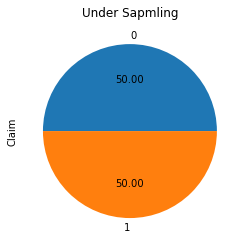

In [316]:
rus = RandomUnderSampler(sampling_strategy= 1)

X_res, y_res = rus.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct= '%.2f')
_ = ax.set_title("Under Sapmling")

In [317]:
df_clean['Claim'].value_counts()

0    43649
1    677  
Name: Claim, dtype: int64

In [318]:
y_res.value_counts()

0    677
1    677
Name: Claim, dtype: int64

Can be seen from above, our target (y_res) classes are now balanced.

In [319]:
# Train test split with balanced data

X_train_rus, X_test_rus, y_train_rus, y_test_rus= train_test_split(
    X_res,
    y_res,
    stratify= y_res,  
    test_size= 0.2,
    random_state= 2023)

In [320]:
# Cross validation With balanced data

# Models
models = [logreg, knn, tree, rf]

score_precision = []
mean_precision = []
std_precision = []

# Loop every models for each metrics
for i in models:

    crossval = StratifiedKFold(n_splits= 5)

    pipe = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    # precision
    model_cv_precision = cross_val_score(
        pipe, 
        X_train_rus, 
        y_train_rus, 
        cv= crossval,
        scoring= 'precision')

    # print(model_cv_precision, i)

    score_precision.append(model_cv_precision)
    mean_precision.append(model_cv_precision.mean())
    std_precision.append(model_cv_precision.std())

precision_before_tuning_rus = pd.DataFrame({'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],'mean precision': mean_precision, 'std': std_precision}).set_index('model').sort_values(by= 'mean precision', ascending= False)
precision_before_tuning_rus

,mean precision,std
model,,
Logistic Regression,0.782064,0.045056
Random Forest,0.737473,0.034048
Decision Tree,0.664871,0.029621
KNN,0.653388,0.029955


Now lets try with random over sampling.

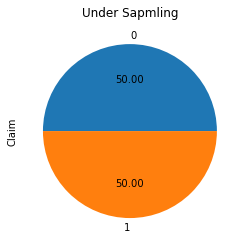

In [321]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy= 'minority')

X_ros, y_ros = ros.fit_resample(X, y)

ax = y_ros.value_counts().plot.pie(autopct= '%.2f')
_ = ax.set_title("Over Sapmling")

In [322]:
df_clean['Claim'].value_counts()

0    43649
1    677  
Name: Claim, dtype: int64

In [323]:
y_ros.value_counts()

0    43649
1    43649
Name: Claim, dtype: int64

In [324]:
# Train test split with balanced data

X_train_ros, X_test_ros, y_train_ros, y_test_ros= train_test_split(
    X_ros,
    y_ros,
    stratify= y_ros,  
    test_size= 0.2,
    random_state= 2023)

In [325]:
# Cross validation With balanced data

# Models
models = [logreg, knn, tree, rf]

score_precision = []
mean_precision = []
std_precision = []

# Loop every models for each metrics
for i in models:

    crossval = StratifiedKFold(n_splits= 5)

    pipe = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    # precision
    model_cv_precision = cross_val_score(
        pipe, 
        X_train_ros, 
        y_train_ros, 
        cv= crossval,
        scoring= 'precision')

    # print(model_cv_precision, i)

    score_precision.append(model_cv_precision)
    mean_precision.append(model_cv_precision.mean())
    std_precision.append(model_cv_precision.std())

precision_before_tuning_ros = pd.DataFrame({'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],'mean precision': mean_precision, 'std': std_precision}).set_index('model').sort_values(by= 'mean precision', ascending= False)
precision_before_tuning_ros

,mean precision,std
model,,
Random Forest,0.987083,0.001086
Decision Tree,0.978540,0.002374
KNN,0.936625,0.002459
Logistic Regression,0.786104,0.004258


With balancing treatment from both random under and over sampling, it greatly improved the precision mean score.

Because we want to use "real" data we would be using undersampling even though we lose a significant amount of information.

In [326]:
precision_before_tuning_rus

,mean precision,std
model,,
Logistic Regression,0.782064,0.045056
Random Forest,0.737473,0.034048
Decision Tree,0.664871,0.029621
KNN,0.653388,0.029955


From under sampling the data it can be seen that `Logistic Regression` is the best algorithm with mean precision of 79%, followed by `Random Forest`.

Next lets tune the Logistic Regression algorithm to see if we can increase the precision score.

#### Hyperparameter Tuning

In [327]:
logreg = LogisticRegression()

tuning_pipe = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

hyperparam_space = {
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__C': [0.1, 1.0, 10.0],
    'model__fit_intercept': [True, False],
    'model__solver': ['lbfgs', 'sag', 'saga'],
    'model__max_iter': [100, 500],
    'model__multi_class': ['auto', 'ovr']
}

skf = StratifiedKFold(n_splits = 5)

grid_search = GridSearchCV(
    tuning_pipe, 
    param_grid = hyperparam_space, 
    cv = skf,
    scoring = 'precision', 
    n_jobs = -1
)

Logistic Regression default parameters: penalty= 'l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None.

In [328]:
grid_search.fit(X_train_rus, y_train_rus)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Agency '
                                                                          'Type',
                                                                          'Gender']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination'])])),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1.0, 10.0],
                         'model__fit_intercept': [True, False],
                         'model__max_iter': [100, 500],
                         'model__multi_class': ['auto', 'ovr'],
                         'model__penalty': ['l2', 'l1', 'elasticnet'],
                         'model__solver': ['lbfgs', 'sag', 'saga']},
             scoring='precision')

In [329]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score 0.7912827162834477
best param {'model__C': 0.1, 'model__fit_intercept': False, 'model__max_iter': 100, 'model__multi_class': 'auto', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


Before Tuning:

In [330]:
model = LogisticRegression()

estimator = Pipeline([('preprocess', transformer), ('model', model)])

estimator.fit(X_train_rus, y_train_rus)
y_pred_rus = estimator.predict(X_test_rus)

print(classification_report(y_test_rus, y_pred_rus))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       135
           1       0.79      0.76      0.77       136

    accuracy                           0.78       271
   macro avg       0.78      0.78      0.78       271
weighted avg       0.78      0.78      0.78       271



After Tuning:

In [331]:
grid_search.best_estimator_.fit(X_train_rus, y_train_rus)
y_pred_rus = grid_search.best_estimator_.predict(X_test_rus)

print(classification_report(y_test_rus, y_pred_rus))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       135
           1       0.81      0.77      0.79       136

    accuracy                           0.80       271
   macro avg       0.80      0.80      0.80       271
weighted avg       0.80      0.80      0.80       271



For a balanced dataset with random under sampling and tuning, the precision score for logistic regression increased by 2%.

## Conclusion & Recommendation

In [332]:
precision_before_tuning

,mean precision,std
model,,
Random Forest,0.105035,0.060753
Decision Tree,0.049652,0.010320
KNN,0.028571,0.057143
Logistic Regression,0.000000,0.000000


In conclusion since the dataset only has 2% historical data of policyholders who claimed an insurance. For our model goals to reduce the false positive rate by seeing the mean precision above the model performance is very poor with Random Forest algorithm the best algorithm but only at 10% mean precision score.

In [333]:
precision_before_tuning_rus

,mean precision,std
model,,
Logistic Regression,0.782064,0.045056
Random Forest,0.737473,0.034048
Decision Tree,0.664871,0.029621
KNN,0.653388,0.029955


In [334]:
precision_before_tuning_ros

,mean precision,std
model,,
Random Forest,0.987083,0.001086
Decision Tree,0.978540,0.002374
KNN,0.936625,0.002459
Logistic Regression,0.786104,0.004258


However if we were to balanced the minority class and majority class, it can be seen that there is a significant amount of score jump. For our goals we would be then based on the model from data that has gone random undersampling treatment as the minority class is based on "real" historical data and not a made up data. Next, the best algorithm to be chosen would be Logistic Regression.

In [336]:
print(classification_report(y_test_rus, y_pred_rus))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       135
           1       0.81      0.77      0.79       136

    accuracy                           0.80       271
   macro avg       0.80      0.80      0.80       271
weighted avg       0.80      0.80      0.80       271



After tuning it can be seen that the precision score for our positive class increases by 2%. So our model with Logistic Regression after it is tuned can reduce the false positive rate. Which can help the company to predict policyholders who will more likely to make a claim in  the future.

It can be then recommended that this data needs to have more policyholders who claimed. Our goal in predicting 'claim' was very poor until the dataset was given a random sampling treatment.

Thank You.